In [143]:
from typing import Optional, List
from pathlib import Path
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, linprog
import statsmodels.api as sm

#necessary to import preprocessing module
sys.path.append(str(Path(os.getcwd()).parent.parent.absolute()))

import preprocessing as pp

In [3]:
df = pd.read_csv('./../../jpx/train_files/stock_prices.csv')
fin_df = pd.read_csv('./../../jpx/train_files/financials.csv')
trades_df = pd.read_csv('./../../jpx/train_files/trades.csv')
options_df = pd.read_csv('./../../jpx/train_files/options.csv')
secondary_stock_df = pd.read_csv('./../../jpx/train_files/secondary_stock_prices.csv')

c:\Users\darth\Anaconda3\envs\aws\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


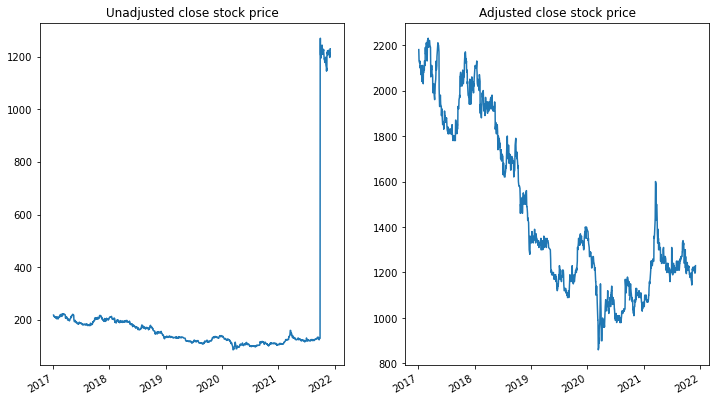

In [153]:
fig, axs = plt.subplots(1,2)
pp.get_stock_data(8713, stock_price_dataframe=df).Close.plot(ax=axs[0], title='Unadjusted close stock price')
pp.get_adjusted_stock_data(8713, stock_price_dataframe=df).Close.plot(ax=axs[1], title='Adjusted close stock price')
fig.set_size_inches(12,7)

<AxesSubplot:>

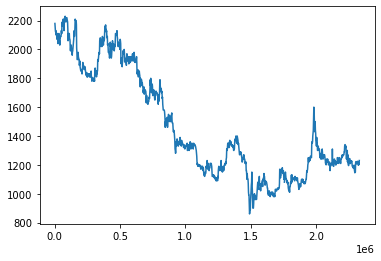

In [36]:
(df.query("SecuritiesCode==8713").sort_values('Date', ascending=False)['AdjustmentFactor'].cumprod().sort_index() * df.query("SecuritiesCode==8713").sort_values('Date').Close).plot()

In [37]:
test = pd.DataFrame(index=date_index)

In [39]:
stock_list_df = pd.read_csv('./../../jpx/stock_list.csv')

In [45]:
adjusted_dfs = list()
securities_list = df.SecuritiesCode.sort_values().unique().tolist()

In [121]:
def get_date_index(
    stock_price_dataframe: pd.DataFrame,
    date_column_name: str = "Date",
) -> pd.DatetimeIndex:
    return pd.to_datetime(
        stock_price_dataframe[date_column_name].unique()
    ).sort_values()


def get_adjustment_series(
    stock_data: pd.DataFrame,
    adjustment_factor_column: str = "AdjustmentFactor",
    adjustment_type: str = "price",
) -> pd.Series:
    """
    Returns a sorted series that enables price or volume adjustment based on
    elementwise multiplication.

    Args:
        stock_data: Stock dataframe of a single security indexed by date.
        adjustment_dactor_column: Name of the column that stores adjustment
            factors.
        adjustment_type: Takes 'price' or 'volume' as input, and alters
            adjustment factor series likewise.
    Returns:
        Adjustment factor time series that can be employed to adjust either
        price or volume time series through elementwise multiplication.
    Raises:
        ValueError: if adjustment_type value is neither 'price' or 'volume'.

    """
    if adjustment_type not in ["price", "volume"]:
        raise ValueError(
            "adjustment_type value is neither 'price' nor 'volume'"
        )

    if adjustment_type == "volume":
        return (
            1
            / stock_data.sort_index(ascending=False)[
                f"{adjustment_factor_column}"
            ]
            .cumprod()
            .sort_index()
        )

    return (
        stock_data.sort_index(ascending=False)[f"{adjustment_factor_column}"]
        .cumprod()
        .sort_index()
    )


def get_stock_data(
    security_code: int,
    stock_price_dataframe: pd.DataFrame,
    code_column_name: str = "SecuritiesCode",
    date_column_name: str = "Date",
) -> pd.DataFrame:

    date_index = get_date_index(
        stock_price_dataframe=stock_price_dataframe,
        date_column_name=date_column_name,
    )

    return (
        stock_price_dataframe.query(f"{code_column_name}=={security_code}")
        .sort_values(date_column_name)
        .set_index(date_index)
        .drop([code_column_name, date_column_name], axis=1)
        .copy()
    )


def get_adjusted_stock_data(
    security_code: int,
    stock_price_dataframe: pd.DataFrame,
    code_column_name: str = "SecuritiesCode",
    date_column_name: str = "Date",
    volume_column_name: str = "Volume",
    adjustment_factor_column: str = "AdjustmentFactor",
    price_columns: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Returns the adjusted prices and volumes, given the stock dataframe and
    security code.

    Args:
        security_code:
    """

    if not price_columns:
        price_columns = ["High", "Low", "Open", "Close"]

    stock_data = get_stock_data(
        security_code=security_code,
        stock_price_dataframe=stock_price_dataframe,
        code_column_name=code_column_name,
        date_column_name=date_column_name,
    )

    for price_column in price_columns:
        stock_data[price_column] = (
            get_adjustment_series(
                stock_data=stock_data,
                adjustment_factor_column=adjustment_factor_column,
                adjustment_type="price",
            )
            * stock_data[price_column]
        )

    stock_data[volume_column_name] = (
        get_adjustment_series(
            stock_data=stock_data,
            adjustment_factor_column=adjustment_factor_column,
            adjustment_type="volume",
        )
        * stock_data[volume_column_name]
    )

    return stock_data


<AxesSubplot:>

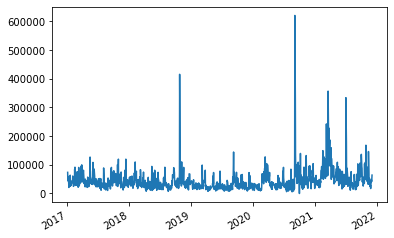

In [125]:
adjusted_stock_data = get_adjusted_stock_data(8713, stock_price_dataframe=df)
adjusted_stock_data.Volume.plot()

DatetimeIndex(['2021-09-28'], dtype='datetime64[ns]', freq=None)


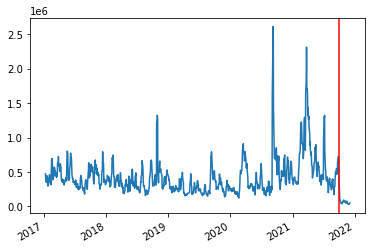

In [87]:
tmp = (
    df.query("SecuritiesCode==8713")
    .sort_values("Date")
    .set_index(date_index)
    .drop(["SecuritiesCode", "Date"], axis=1)
    .copy()
)
print(tmp[tmp.AdjustmentFactor > 1].index)
tmp.Volume.rolling(5).mean().plot()

plt.axvline(tmp[tmp.AdjustmentFactor > 1].index[0], color='red')

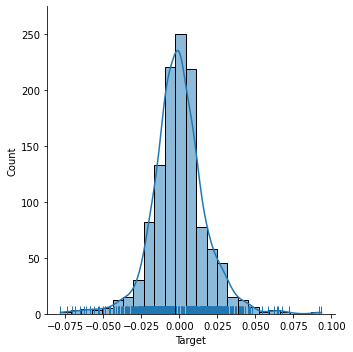

In [105]:
sns.displot(tmp.Target, bins=25, kde=True, rug=True)

(-0.1, 0.1)

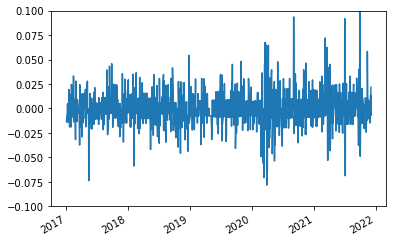

In [94]:
tmp.Close.pct_change().plot()
plt.ylim([-0.1, 0.1])